In [32]:
pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


In [33]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [34]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [35]:
def list_files_from_zip_url(zip_url):
    """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
    """
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
        return files

In [36]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [37]:
def get_class(fname):
    """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
    """
    return fname.split('_')[-3]

In [38]:
def get_files_per_class(files):
    """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

In [39]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [40]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [41]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [43]:
def select_subset_of_classes(files_for_class, classes, FILES_PER_CLASS):
    """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
    """
    files_subset = dict()
    
    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:FILES_PER_CLASS]
    return files_subset

In [45]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [46]:
def download_from_zip(zip_url, to_dir, file_names):
    """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
    """
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn
            
            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

In [47]:
def split_class_lists(files_for_class, count):
    """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

In [50]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
    """ Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
    """
    files = list_files_from_zip_url(zip_url)
    for f in files:
        path = os.path.normpath(f)
        tokens = path.split(os.sep)
        if len(tokens) <= 2:
            files.remove(f)
            
    files_for_class = get_files_per_class(files)
    
    classes = list(files_for_class.keys())[:num_classes]
    
    for cls in classes:
        random.shuffle(files_for_class[cls])
    
    files_for_class = {x: files_for_class[x] for x in classes}
    
    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ':')
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir
        
    return dirs

In [51]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, num_classes = NUM_CLASSES, 
                                       splits = {'train': 30, 'val': 10, 'test': 10}, 
                                      download_dir = download_dir)

train :


100%|█████████████████████████████████████████| 300/300 [01:37<00:00,  3.07it/s]


val :


100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


test :


100%|█████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


In [52]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [54]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/test
./UCF101_subset/test/BalanceBeam
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g12_c02.avi
./UCF101_subset/test/BalanceBeam/UCF101
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g10_c04.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g15_c03.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g05_c03.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g14_c03.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g21_c05.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g17_c05.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g06_c05.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g17_c03.avi
./UCF101_subset/test/BalanceBeam/v_BalanceBeam_g21_c01.avi
./UCF101_subset/test/BaseballPitch
./UCF101_subset/test/BaseballPitch/UCF101
./UCF101_subset/test/BaseballPitch/v_BaseballPitch_g01_c06.avi
./UCF101_subset/test/BaseballPitch/v_BaseballPitch_g10_c03.avi
./UCF101_subset/test/BaseballPitch/v_BaseballPitch_g18_c04.avi
./UCF101_subset/test/BaseballPitch

In [55]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [56]:
def frames_from_video_file(video_path, n_frames, output_size = (224, 224), frame_step = 15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    result = []
    src = cv2.VideoCapture(str(video_path))
    
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    
    need_length = 1 + (n_frames - 1) * frame_step
    
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)
        
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))
    
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    
    return result
            


In [57]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  10.2M      0  0:00:05  0:00:05 --:--:-- 10.9M


In [58]:
video_path = "End_of_a_jam.ogv"

In [59]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [64]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')


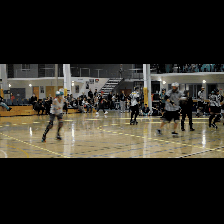

In [65]:
to_gif(sample_video)


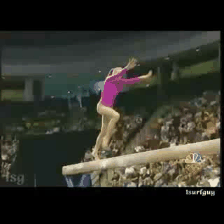

In [66]:
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

In [68]:
class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        """ Returns a set of frames with their associated label. 

        Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))
        
    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes
    
    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        
        pairs = list(zip(video_paths, classes))
        
        if self.training:
            random.shuffle(pairs)
        
        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [69]:
fg = FrameGenerator(subset_paths['train'], 10, training = True)
frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 8


In [70]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), 
                   tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training = True), 
                                         output_signature = output_signature)

In [71]:
for frames, labels in train_ds.take(10):
    print(labels)

tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(6, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


In [72]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10), 
                                       output_signature = output_signature)

In [73]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [75]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

2022-12-28 16:54:02.920951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 262 of 1000
2022-12-28 16:54:04.321358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


In [76]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale = 255), 
    tf.keras.layers.TimeDistributed(net), 
    tf.keras.layers.Dense(10), 
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
             metrics = ['accuracy'])

model.fit(train_ds, epochs = 10, 
         validation_data = val_ds, 
         callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

Epoch 1/10
150/150 [==============================] - 236s 2s/step - loss: 1.7951 - accuracy: 0.3667 - val_loss: 1.5792 - val_accuracy: 0.5100
Epoch 2/10
150/150 [==============================] - 225s 1s/step - loss: 1.0887 - accuracy: 0.6400 - val_loss: 1.2251 - val_accuracy: 0.7300
Epoch 3/10
150/150 [==============================] - 225s 1s/step - loss: 0.7951 - accuracy: 0.7733 - val_loss: 0.5242 - val_accuracy: 0.8800
Epoch 4/10
150/150 [==============================] - 271s 2s/step - loss: 0.5289 - accuracy: 0.8367 - val_loss: 1.0643 - val_accuracy: 0.8000
Epoch 5/10
150/150 [==============================] - 227s 2s/step - loss: 0.4011 - accuracy: 0.8633 - val_loss: 0.7279 - val_accuracy: 0.8300
